In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

Here the results from 'Adult EDA" file are going to be used

In [2]:
# %run "Adult EDA.ipynb"

In [3]:
adult_columns = [
    "Age",
    "Workclass",
    "final weight",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Income",
]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                 header = None, names = adult_columns)

In [4]:
df = df.drop(['Education-Num'], axis = 'columns')

## 1. Initial logistic regression without any changes in data

First all variables have to be transformed to numerical format to feed them to Logit function:

In [5]:
_ = df['Income'].replace({' <=50K': 0, 
                             ' >50K': 1}, 
                            inplace = True)


'Sex' feature is also binary, we can convert it separately from other categorical features.

In [6]:
_ = df['Sex'].replace({' Male': 0, ' Female': 1}, 
                      inplace = True)

In [7]:
numerical_features_df = df[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'final weight']]

In [8]:
X = df.drop(['Income'], axis = 'columns')
y = df['Income']

In [9]:
def reset_xy (df):
    X = df.drop(['Income', 'final weight'], axis = 'columns')
    y = df['Income']
    return X, y

In [10]:
stand_scaler = StandardScaler()

In [11]:
def scale_numerical(numerical_features):
    X[numerical_features.columns.values] = stand_scaler.fit_transform(numerical_features.values)
    
scale_numerical(numerical_features_df)

In [12]:
X.sample()

,Age,Workclass,final weight,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
13472,-1.142331,Private,0.801961,11th,Separated,Other-service,Unmarried,White,1,-0.14592,-0.21666,-0.035429,United-States


In this dataset we have only one feature, where the order matters - Education. Let's transform it using OrdinalEncoder. 

In [13]:
edu_encoder = OrdinalEncoder(categories=[[' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                                      ' 12th',' HS-grad',' Some-college',' Assoc-voc',' Assoc-acdm', 
                                      ' Bachelors',' Masters',' Prof-school',' Doctorate']])

In [14]:
def encode_edu():
    X[["Education"]] = edu_encoder.fit_transform(df[["Education"]])
    
encode_edu()

For all the rest of categorical features the order does not matter, hense we can use dummies values approach

In [15]:
categorical_features_df = df[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Country']]

In [16]:
def encode_categorical(categorical_features_df):
    cat_df = categorical_features_df.apply(LabelEncoder().fit_transform)
    return cat_df

cat_df = encode_categorical(categorical_features_df)

In [17]:
def add_num_and_cat(x, cat):
    X = x.drop(cat.columns, axis = 'columns')
    X = pd.concat([X, cat], axis=1, join='inner')
    return X

In [18]:
X = add_num_and_cat(X, cat_df)
X

,Age,final weight,Education,Sex,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Occupation,Relationship,Ethnic group,Country
0,0.030671,-1.063611,12.0,0,0.148453,-0.21666,-0.035429,7,4,1,1,4,39
1,0.837109,-1.008707,12.0,0,-0.145920,-0.21666,-2.222153,6,2,4,0,4,39
2,-0.042642,0.245079,8.0,0,-0.145920,-0.21666,-0.035429,4,0,6,1,4,39
3,1.057047,0.425801,6.0,0,-0.145920,-0.21666,-0.035429,4,2,6,0,2,39
4,-0.775768,1.408176,12.0,1,-0.145920,-0.21666,-0.035429,4,2,10,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.639741,11.0,1,-0.145920,-0.21666,-0.197409,4,2,13,5,4,39
32557,0.103983,-0.335433,8.0,0,-0.145920,-0.21666,-0.035429,4,2,7,0,4,39
32558,1.423610,-0.358777,8.0,1,-0.145920,-0.21666,-0.035429,4,6,1,4,4,39
32559,-1.215643,0.110960,8.0,0,-0.145920,-0.21666,-1.655225,4,4,1,3,4,39


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [20]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.397817
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26035
Method:                           MLE   Df Model:                           12
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                  0.2809
Time:                        22:40:57   Log-Likelihood:                -10362.
converged:                       True   LL-Null:                       -14410.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.3759      0.020     18.823      0.000       0.337       0.415
final weight     

In [21]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[[4672  300]
 [ 887  654]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4972
           1       0.69      0.42      0.52      1541

    accuracy                           0.82      6513
   macro avg       0.76      0.68      0.71      6513
weighted avg       0.80      0.82      0.80      6513



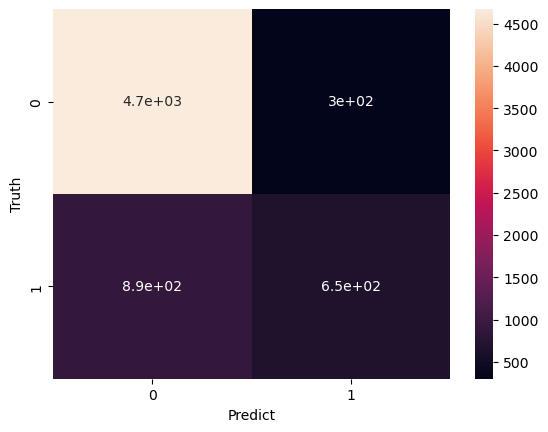

In [22]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

## Same model, but without 'final weight' parameter

In [23]:
X, y = reset_xy(df)

In [25]:
num_no_fw = X[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']]
scale_numerical(num_no_fw)

In [26]:
encode_edu()
cat_df = encode_categorical(categorical_features_df)

In [27]:
X = add_num_and_cat(X, cat_df)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [29]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.399746
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26036
Method:                           MLE   Df Model:                           11
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                  0.2752
Time:                        22:42:54   Log-Likelihood:                -10413.
converged:                       True   LL-Null:                       -14365.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.3793      0.020     19.095      0.000       0.340       0.418
Education        

In [30]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Predictions : [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


[[4652  281]
 [ 909  671]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4933
           1       0.70      0.42      0.53      1580

    accuracy                           0.82      6513
   macro avg       0.77      0.68      0.71      6513
weighted avg       0.80      0.82      0.80      6513



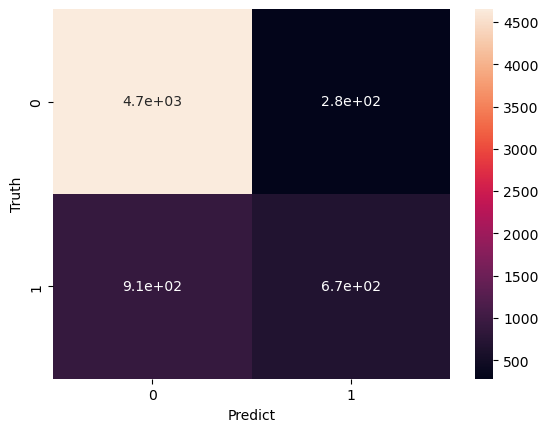

In [31]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

## Same model, but with Capital paremeters logged

In [32]:
X, y = reset_xy(df)

In [33]:
def capital_log():
    X['Capital Gain'] = np.log(1+ X['Capital Gain'])
    X['Capital Loss'] = np.log(1+ X['Capital Loss'])
    
capital_log()

In [34]:
num_no_capital = X[['Age', 'Hours per week']]
scale_numerical(num_no_capital)

In [35]:
X.head(2)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0.030671,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,0,7.684784,0.0,-0.035429,United-States
1,0.837109,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,0,0.000000,0.0,-2.222153,United-States


In [37]:
encode_edu()
cat_df = encode_categorical(categorical_features_df)

In [38]:
X = add_num_and_cat(X, cat_df)

In [39]:
X.head()

,Age,Education,Sex,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Occupation,Relationship,Ethnic group,Country
0,0.030671,12.0,0,7.684784,0.0,-0.035429,7,4,1,1,4,39
1,0.837109,12.0,0,0.000000,0.0,-2.222153,6,2,4,0,4,39
2,-0.042642,8.0,0,0.000000,0.0,-0.035429,4,0,6,1,4,39
3,1.057047,6.0,0,0.000000,0.0,-0.035429,4,2,6,0,2,39
4,-0.775768,12.0,1,0.000000,0.0,-0.035429,4,2,10,5,2,5


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [41]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.413653
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26036
Method:                           MLE   Df Model:                           11
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                  0.2511
Time:                        22:44:45   Log-Likelihood:                -10775.
converged:                       True   LL-Null:                       -14387.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.4088      0.019     21.051      0.000       0.371       0.447
Education        

In [42]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))
print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Predictions : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[[4573  379]
 [ 906  655]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      4952
           1       0.63      0.42      0.50      1561

    accuracy                           0.80      6513
   macro avg       0.73      0.67      0.69      6513
weighted avg       0.79      0.80      0.79      6513



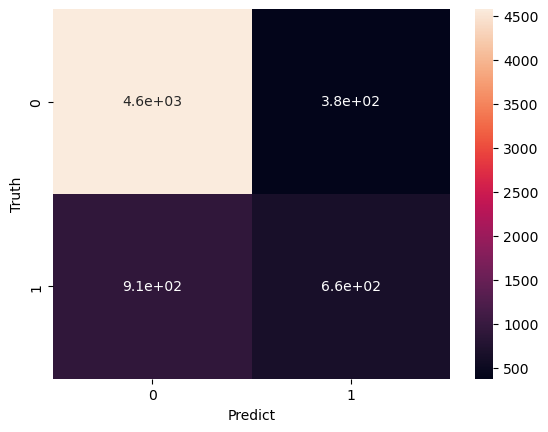

In [43]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

## Logistic regression with previous data transformation

In [44]:
X, y = reset_xy(df)

In [45]:
def balance_predictors():
    X['Ethnic group'] = np.where(df['Ethnic group'] != ' White', 'Other', df['Ethnic group'])
    X['Country'] = np.where(df['Country'] != ' United-States', 'Other', df['Country'])
    X['Workclass'] = np.where(df['Workclass'] != ' Private', 'Other', df['Workclass'])
    
balance_predictors()
X.sample(3)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
32319,54,Private,HS-grad,Widowed,Sales,Not-in-family,White,1,0,0,37,United-States
18516,17,Private,11th,Never-married,Other-service,Own-child,White,0,0,0,25,United-States
5638,25,Private,Bachelors,Never-married,Craft-repair,Own-child,White,0,0,0,40,United-States


In [46]:
encode_edu()

In [47]:
capital_log()

scale_numerical(num_no_fw)

In [48]:
X.sample()

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
30268,1.570235,Other,4.0,Widowed,?,Not-in-family,White,1,-0.14592,-0.21666,-0.035429,United-States


In [49]:
categorical_features_df = X[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Country']]

In [50]:
cat_df = encode_categorical(categorical_features_df)

In [51]:
X = add_num_and_cat(X, cat_df)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [53]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.417992
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26036
Method:                           MLE   Df Model:                           11
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                  0.2418
Time:                        22:46:58   Log-Likelihood:                -10888.
converged:                       True   LL-Null:                       -14361.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.2900      0.019     14.937      0.000       0.252       0.328
Education        

In [54]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Predictions : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0]


[[4634  295]
 [1017  567]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      4929
           1       0.66      0.36      0.46      1584

    accuracy                           0.80      6513
   macro avg       0.74      0.65      0.67      6513
weighted avg       0.78      0.80      0.78      6513



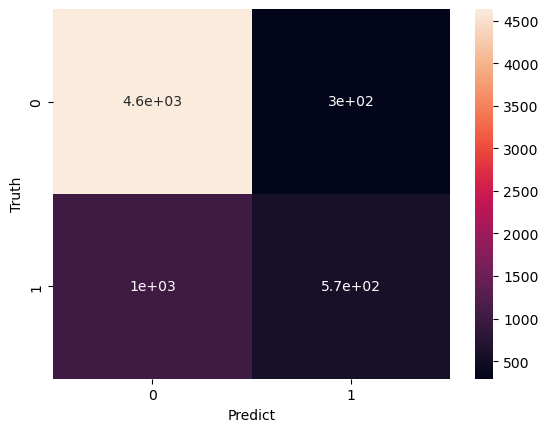

In [55]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))

## Oversampling target

In [93]:
count_class_0, count_class_1 = df['Income'].value_counts()

y0 = df[df['Income'] == 0]
y1 = df[df['Income'] == 1]

In [94]:
print(y0.shape)
print(y1.shape)

(24720, 14)
(24720, 14)


In [95]:
y1_over = y1.sample(count_class_0, replace = True)

In [96]:
df = pd.concat([y0, y1_over], axis = 0)

In [97]:
df.shape

(49440, 14)

In [98]:
X, y = reset_xy(df)

In [99]:
# balance_predictors()

In [100]:
encode_edu()

In [101]:
capital_log()

In [102]:
num_no_capital = X[['Age', 'Hours per week']]
scale_numerical(num_no_capital)

In [103]:
categorical_features_df = X[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Country']]
cat_df = encode_categorical(categorical_features_df)

In [104]:
X = add_num_and_cat(X, cat_df)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
X_train.sample(3)

,Age,Education,Sex,Capital Gain,Capital Loss,Hours per week,Workclass,Marital Status,Occupation,Relationship,Ethnic group,Country
9658,1.266033,1.0,0,0.0,0.0,-0.173462,4,2,8,0,3,6
30618,-0.427444,8.0,1,0.0,0.0,-0.173462,4,4,8,1,4,39
17883,-0.350468,9.0,1,0.0,0.0,0.484531,2,4,4,4,2,39


In [106]:
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.490267
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                39552
Model:                          Logit   Df Residuals:                    39540
Method:                           MLE   Df Model:                           11
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                  0.2927
Time:                        23:28:18   Log-Likelihood:                -19391.
converged:                       True   LL-Null:                       -27415.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.4990      0.014     35.279      0.000       0.471       0.527
Education        

In [107]:
y_hat = model.predict(X_test)
prediction = list(map(round, y_hat))

print('Actual values', list(y_test.values)[:10])
print('Predictions :', prediction[:10])

Actual values [1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
Predictions : [1, 0, 1, 0, 0, 0, 0, 0, 1, 0]


[[3664 1295]
 [1034 3895]]
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      4959
           1       0.75      0.79      0.77      4929

    accuracy                           0.76      9888
   macro avg       0.77      0.76      0.76      9888
weighted avg       0.77      0.76      0.76      9888



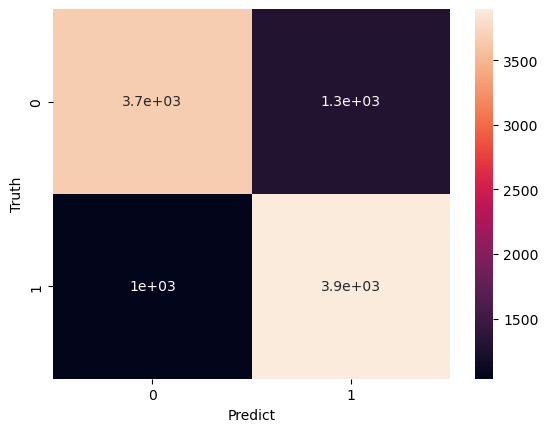

In [108]:
cm = confusion_matrix(y_test, prediction) 
s = sns.heatmap(cm, annot = True)
s.set(xlabel='Predict', ylabel='Truth')
print(cm)
print(classification_report(y_test, prediction))